<a href="https://colab.research.google.com/github/arbouria/Notas-Aprendizaje-y-Comportamiento-Adaptable-I/blob/main/Copia_de_simulador_concurrente_RV_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dor concurrente RV y VI

Output()

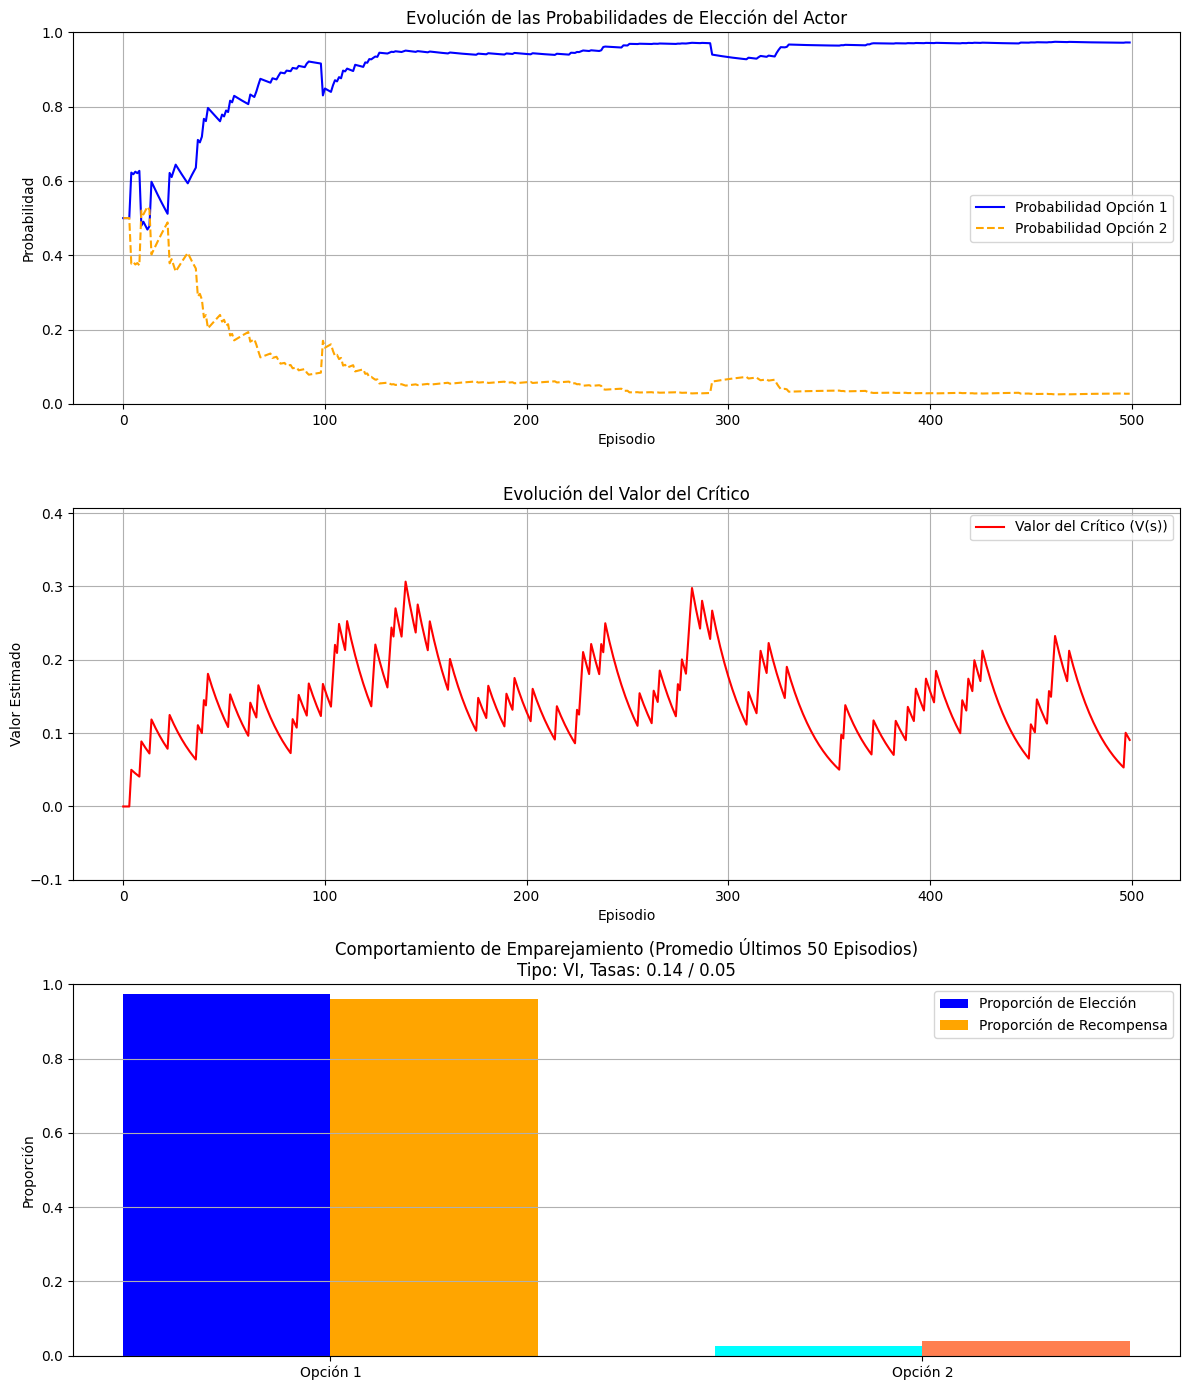

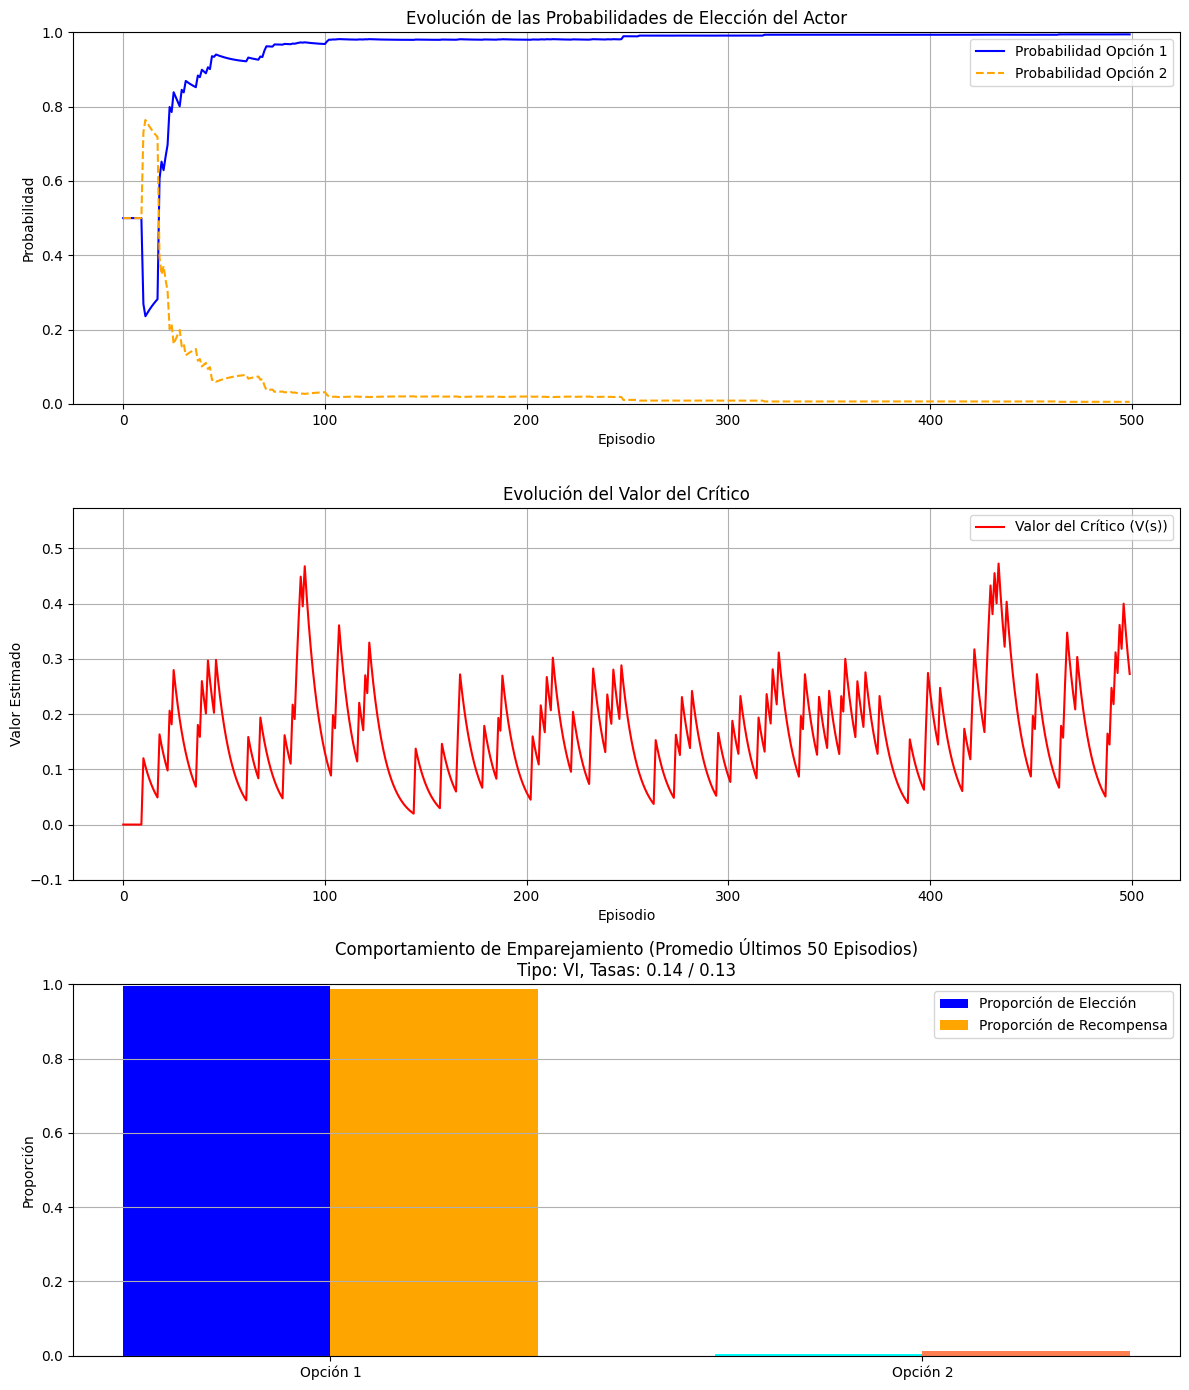

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, Dropdown, Button, Output
import io
import random

# --- Configuración Inicial ---
# Parámetros del Actor-Critic
ALPHA_CRITIC = 0.05  # Tasa de aprendizaje del Crítico (α_c)
ALPHA_ACTOR = 0.1    # Tasa de aprendizaje del Actor (α_a) - φ en tu artículo
DECAY_RATE_ACTOR = 1.0 # Tasa de decaimiento (η) para las preferencias del actor. Usualmente 1.0 para no decaer
BETA_SOFTMAX = 5.0   # Parámetro de temperatura para Softmax (β). Más alto = más "greedy"

# Parámetros de la simulación
NUM_EPISODES = 500  # Número de interacciones (elecciones)
PROGRAM_TYPE = 'VI' # 'VR' o 'VI'
REWARD_RATE_1 = 0.1 # Tasa de recompensa para la Opción 1
REWARD_RATE_2 = 0.05 # Tasa de recompensa para la Opción 2

# --- Variables del Simulador (GLOBALES, para poder reiniciarlas fácilmente) ---
actor_preferences = {'Option 1': 0.0, 'Option 2': 0.0}
critic_value = 0.0
history_choice_prob = {'Option 1': [], 'Option 2': []}
history_critic_value = []
history_reward_per_option = {'Option 1': 0, 'Option 2': 0} # Recompensas acumuladas por opción para la ley de emparejamiento

# Para VI, necesitamos un "estado" de recompensa disponible que persiste hasta que se recoge
reward_available = {'Option 1': False, 'Option 2': False}


# --- Widgets de Control ---
program_type_dropdown = Dropdown(options=['VI', 'VR'], value=PROGRAM_TYPE, description='Tipo de Programa:')
reward_rate_1_slider = FloatSlider(min=0.01, max=0.5, step=0.01, value=REWARD_RATE_1, description='Tasa Recomp. Opción 1:')
reward_rate_2_slider = FloatSlider(min=0.01, max=0.5, step=0.01, value=REWARD_RATE_2, description='Tasa Recomp. Opción 2:')
alpha_critic_slider = FloatSlider(min=0.01, max=0.5, step=0.01, value=ALPHA_CRITIC, description='α Crítico:')
alpha_actor_slider = FloatSlider(min=0.01, max=0.5, step=0.01, value=ALPHA_ACTOR, description='α Actor (φ):')
beta_softmax_slider = FloatSlider(min=0.1, max=10.0, step=0.1, value=BETA_SOFTMAX, description='β Softmax:')
episodes_slider = IntSlider(min=100, max=2000, step=100, value=NUM_EPISODES, description='Episodios:')

run_button = Button(description="Simular")
reset_button = Button(description="Reiniciar")
output_area = Output()

# --- Lógica del Programa de Refuerzo (VI o VR) ---

def get_reward_for_choice(program_type, choice_name, reward_rate_current_option):
    # Nota: reward_rate_current_option es ahora la tasa específica para la opción elegida
    global reward_available

    if program_type == 'VR':
        # En VR, la recompensa se da con una probabilidad directa por respuesta
        reward = 1.0 if random.random() < reward_rate_current_option else 0.0
        return reward

    elif program_type == 'VI':
        # En VI, la recompensa "se libera" con una probabilidad en cada paso de tiempo
        # y luego debe ser "recogida"

        # Si la recompensa aún no está disponible para esta opción, intenta liberarla
        if not reward_available[choice_name]:
            if random.random() < reward_rate_current_option: # reward_rate actúa como lambda_a
                reward_available[choice_name] = True

        # Si la recompensa está disponible y se eligió esta opción, se recoge
        if reward_available[choice_name]:
            reward_available[choice_name] = False # La recompensa se consume
            return 1.0
        else:
            return 0.0

# --- Funciones de Simulación del Actor-Critic ---

def softmax_probabilities(preferences, beta):
    # Calcula las probabilidades de elección usando la función softmax
    # p_a = exp(beta * W_a) / sum(exp(beta * W_a'))
    # Se usa np.exp para evitar overflows con valores grandes de beta
    # Se asegura de que todas las preferencias sean np.float64 para evitar errores de tipo
    prefs_array = np.array(list(preferences.values()), dtype=np.float64)

    # Manejar caso de preferencias muy grandes o muy pequeñas para evitar overflow/underflow
    # Restar el máximo para estabilidad numérica
    max_pref = np.max(prefs_array)
    exp_prefs = np.exp(beta * (prefs_array - max_pref))

    sum_exp_prefs = np.sum(exp_prefs)

    # Manejar el caso de división por cero si todas las preferencias son extremadamente negativas
    if sum_exp_prefs == 0:
        return {name: 1.0 / len(preferences) for name in preferences.keys()}

    names = list(preferences.keys())
    return {names[i]: exp_prefs[i] / sum_exp_prefs for i in range(len(names))}

def choose_action(probabilities):
    # Elige una acción basada en las probabilidades
    choices = list(probabilities.keys())
    probs = list(probabilities.values())
    return random.choices(choices, weights=probs, k=1)[0]

def run_actor_critic_simulation(alpha_c, alpha_a, beta, num_episodes, prog_type, r_rate_1, r_rate_2, decay_actor):
    global actor_preferences, critic_value, history_choice_prob, history_critic_value, history_reward_per_option, reward_available

    # Reiniciar variables globales para la nueva simulación
    actor_preferences = {'Option 1': 0.0, 'Option 2': 0.0}
    critic_value = 0.0
    history_choice_prob = {'Option 1': [], 'Option 2': []}
    history_critic_value = []
    history_reward_per_option = {'Option 1': 0, 'Option 2': 0}
    reward_available = {'Option 1': False, 'Option 2': False} # Reiniciar estado de recompensa VI


    for episode in range(num_episodes):
        # 1. Actor elige la acción
        choice_probs = softmax_probabilities(actor_preferences, beta)
        chosen_option = choose_action(choice_probs)

        # Guardar probabilidades de elección y valor del crítico para el historial (al inicio del paso)
        for option, prob in choice_probs.items():
            history_choice_prob[option].append(prob)
        history_critic_value.append(critic_value)


        # 2. Entorno da la recompensa
        # Determinar la tasa de recompensa para la opción elegida
        current_reward_rate = r_rate_1 if chosen_option == 'Option 1' else r_rate_2
        reward_received = get_reward_for_choice(prog_type, chosen_option, current_reward_rate)

        history_reward_per_option[chosen_option] += reward_received # Acumular recompensas

        # 3. Crítico calcula el TD Error y se actualiza
        # Para este entorno de un solo estado, el Crítico predice el valor general del entorno.
        # TD Error (delta_t) = recompensa_actual - valor_critico_actual (Adaptado para bandidos de un solo estado)
        td_error = reward_received - critic_value

        # Actualización del Crítico
        critic_value += alpha_c * td_error

        # 4. Actor se actualiza usando el TD Error del Crítico
        # La actualización del Actor se basa en el TD error y la forma de la política (softmax)
        # delta W_a = alpha_actor * TD_error * (gradiente_log_prob(accion_tomada))
        # Para softmax, el gradiente_log_prob(a_t|s_t) para la acción a_t es (1 - p(a_t|s_t))
        # y para las acciones no tomadas (a_j), es (-p(a_j|s_t))

        for option_name in actor_preferences.keys():
            if option_name == chosen_option:
                # preference_update = alpha_a * td_error * (1 - choice_probs[option_name])
                actor_preferences[option_name] += alpha_a * td_error * (1 - choice_probs[option_name])
            else:
                # preference_update = alpha_a * td_error * (-choice_probs[option_name])
                actor_preferences[option_name] -= alpha_a * td_error * choice_probs[option_name]

            # Aplicar decaimiento a las preferencias si DECAY_RATE_ACTOR < 1.0 (eta en tu referencia)
            actor_preferences[option_name] *= decay_actor


# --- Funciones de Visualización ---
def plot_results_and_display():
    with output_area:
        output_area.clear_output(wait=True)

        fig, axs = plt.subplots(3, 1, figsize=(12, 14), sharex=False) # sharex=False para el tercer gráfico de barras

        # Gráfico 1: Probabilidad de Elección del Actor
        axs[0].plot(history_choice_prob['Option 1'], label='Probabilidad Opción 1', color='blue')
        axs[0].plot(history_choice_prob['Option 2'], label='Probabilidad Opción 2', color='orange', linestyle='--')
        axs[0].set_title('Evolución de las Probabilidades de Elección del Actor')
        axs[0].set_ylabel('Probabilidad')
        axs[0].set_xlabel('Episodio')
        axs[0].legend()
        axs[0].grid(True)
        axs[0].set_ylim(0, 1) # Probabilidades siempre entre 0 y 1

        # Gráfico 2: Valor del Crítico
        axs[1].plot(history_critic_value, label='Valor del Crítico (V(s))', color='red')
        axs[1].set_title('Evolución del Valor del Crítico')
        axs[1].set_ylabel('Valor Estimado')
        axs[1].set_xlabel('Episodio')
        axs[1].legend()
        axs[1].grid(True)
        # Ajustar límites Y del crítico para mejor visualización
        min_v = min(history_critic_value) if history_critic_value else 0
        max_v = max(history_critic_value) if history_critic_value else 1
        axs[1].set_ylim(min_v - 0.1, max_v + 0.1)


        # Gráfico 3: Ley de Emparejamiento (barras finales)
        # Solo calculamos y mostramos si se han acumulado recompensas
        total_rewards = history_reward_per_option['Option 1'] + history_reward_per_option['Option 2']

        if total_rewards > 0:
            final_choice_ratio_1 = np.mean(history_choice_prob['Option 1'][-50:]) # Promedio de las últimas 50 elecciones
            final_choice_ratio_2 = np.mean(history_choice_prob['Option 2'][-50:])

            final_reward_ratio_1 = history_reward_per_option['Option 1'] / total_rewards
            final_reward_ratio_2 = history_reward_per_option['Option 2'] / total_rewards
        else:
            final_choice_ratio_1, final_choice_ratio_2 = 0.5, 0.5
            final_reward_ratio_1, final_reward_ratio_2 = 0.5, 0.5


        # Asegurarse de que las proporciones sumen 1
        sum_choice = final_choice_ratio_1 + final_choice_ratio_2
        if sum_choice > 0:
            final_choice_ratio_1 /= sum_choice
            final_choice_ratio_2 /= sum_choice

        sum_reward = final_reward_ratio_1 + final_reward_ratio_2
        if sum_reward > 0:
            final_reward_ratio_1 /= sum_reward
            final_reward_ratio_2 /= sum_reward


        labels = ['Opción 1', 'Opción 2']
        choice_ratios = [final_choice_ratio_1, final_choice_ratio_2]
        reward_ratios = [final_reward_ratio_1, final_reward_ratio_2]

        x = np.arange(len(labels))
        width = 0.35

        rects1 = axs[2].bar(x - width/2, choice_ratios, width, label='Proporción de Elección', color=['blue', 'cyan'])
        rects2 = axs[2].bar(x + width/2, reward_ratios, width, label='Proporción de Recompensa', color=['orange', 'coral'])

        axs[2].set_title(f'Comportamiento de Emparejamiento (Promedio Últimos 50 Episodios)\nTipo: {program_type_dropdown.value}, Tasas: {reward_rate_1_slider.value} / {reward_rate_2_slider.value}')
        axs[2].set_ylabel('Proporción')
        axs[2].set_xticks(x)
        axs[2].set_xticklabels(labels)
        axs[2].legend()
        axs[2].set_ylim(0, 1)
        axs[2].grid(axis='y')


        plt.tight_layout()

        # Guardar el gráfico en un buffer y mostrarlo como imagen
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        display(Image(value=buf.read()))

        plt.close(fig) # Cerrar la figura para liberar memoria

        # Mostrar los valores finales de las preferencias y el crítico
        display(HTML("<h3>Valores Finales Aprendidos:</h3>"))
        final_values_html = "<ul>"
        final_values_html += f"<li><b>Crítico (V(s)):</b> {critic_value:.3f}</li>"
        for option, pref in actor_preferences.items():
            final_values_html += f"<li><b>Actor Preferencia {option}:</b> {pref:.3f}</li>"
        display_probs = softmax_probabilities(actor_preferences, beta_softmax_slider.value)
        for option, prob in display_probs.items():
             final_values_html += f"<li><b>Actor Probabilidad {option}:</b> {prob:.3f}</li>"

        final_values_html += f"</ul>"
        display(HTML(final_values_html))


# --- Manejadores de Eventos de los Widgets ---
def on_run_button_clicked(b):
    with output_area: # Wrap the entire execution in the output_area context
        run_actor_critic_simulation(alpha_critic_slider.value, alpha_actor_slider.value,
                                    beta_softmax_slider.value, episodes_slider.value,
                                    program_type_dropdown.value, reward_rate_1_slider.value,
                                    reward_rate_2_slider.value, DECAY_RATE_ACTOR)
        plot_results_and_display()

def on_reset_button_clicked(b):
    global actor_preferences, critic_value, history_choice_prob, history_critic_value, history_reward_per_option, reward_available

    with output_area: # Wrap the entire reset in the output_area context
        output_area.clear_output()
        actor_preferences = {'Option 1': 0.0, 'Option 2': 0.0}
        critic_value = 0.0
        history_choice_prob = {'Option 1': [], 'Option 2': []}
        history_critic_value = []
        history_reward_per_option = {'Option 1': 0, 'Option 2': 0}
        reward_available = {'Option 1': False, 'Option 2': False}
        display(HTML("<h3>Simulador Reiniciado. Presiona 'Simular' para comenzar de nuevo.</h3>"))

run_button.on_click(on_run_button_clicked)
reset_button.on_click(on_reset_button_clicked)

# --- Disposición de la Interfaz ---
controls = widgets.VBox([
    program_type_dropdown,
    reward_rate_1_slider,
    reward_rate_2_slider,
    alpha_critic_slider,
    alpha_actor_slider,
    beta_softmax_slider,
    episodes_slider,
    widgets.HBox([run_button, reset_button])
])

display(controls, output_area)

Explicación del Simulador Actor-Critic para VR/VI:

Parámetros y Variables Globales:

ALPHA_CRITIC (α_c): Tasa de aprendizaje del Crítico.


ALPHA_ACTOR (α_a o φ): Tasa de aprendizaje del Actor.

DECAY_RATE_ACTOR (η): Tasa de decaimiento de las preferencias del Actor. Se deja en 1.0 (sin decaimiento) por simplicidad inicial, pero se puede ajustar.

BETA_SOFTMAX (β): Parámetro de temperatura de la función softmax. Controla cuán "greedy" es el Actor. Un valor alto significa que la opción con una preferencia ligeramente mayor tendrá una probabilidad de elección mucho mayor.

actor_preferences: Representa q_a o W_i en algunos modelos Actor-Critic, que son los "logits" o "preferencias" internas del Actor para cada opción.

critic_value: Representa V(s), la estimación del valor de estado por parte del Crítico.

history_choice_prob, history_critic_value, history_reward_per_option: Para registrar la evolución y calcular el emparejamiento.

softmax_probabilities(preferences, beta):

Toma las preferencias del Actor y las convierte en probabilidades de elección. Esto es crucial para la exploración y la plasticidad del Actor.



get_reward_for_choice(program_type, choice_name, reward_rate):

Esta función simula la lógica de los programas VR y VI:

VR: Si se elige la opción, hay una reward_rate de obtener 1.0, de lo contrario 0.0.

VI: Se implementa con un sistema de "disponibilidad": si la recompensa ya está available, se recoge. Si no lo está, se intenta "liberar" con la reward_rate (actuando como lambda, la tasa de liberación de recompensa en VI). Esto simula la naturaleza temporal e independiente de la respuesta de VI.

run_actor_critic_simulation(...):

Bucle de Episodios: Cada episodio representa una interacción (una elección y sus consecuencias).

Actor (Elige):

Calcula choice_probs usando softmax_probabilities y las preferencias actuales.

chosen_option = choose_action(choice_probs) selecciona la acción de manera probabilística.

Entorno (Recompensa):

reward_received = get_reward_for_choice(...) obtiene la recompensa según el programa y la opción elegida.

history_reward_per_option acumula las recompensas para calcular la Ley de Emparejamiento al final.

Crítico (Evalúa y Aprende):

td_error = reward_received - critic_value. En este contexto de un solo estado, el Crítico predice el valor promedio del entorno. El error es la diferencia entre la recompensa obtenida y esa predicción.


critic_value += alpha_c * td_error actualiza la predicción del Crítico.

Actor (Aprende):

actor_preferences[chosen_option] += alpha_a * td_error * (1 - choice_probs[chosen_option])

actor_preferences[other_option] -= alpha_a * td_error * choice_probs[other_option]

Esta es la regla de actualización de la política del Actor basada en el TD error para una política softmax, que corresponde a un gradiente estocástico.  Un TD error positivo aumenta la preferencia de la opción elegida y disminuye la de la no elegida (relativamente).


plot_results_and_display():

Muestra tres gráficos:

Probabilidades de Elección del Actor: Cómo evolucionan las probabilidades de elegir cada opción a lo largo de los episodios.

Valor del Crítico: Cómo evoluciona la estimación del Crítico sobre la recompensa promedio del entorno.

Ley de Emparejamiento: Una barra de gráficos que compara la proporción de elecciones finales con la proporción de recompensas finales para cada opción. Esto es clave para verificar si se cumple la ley de emparejamiento. En el estado estacionario, estas proporciones deberían ser similares para los programas VI.

Widgets y Eventos: Conectan los sliders y botones a las funciones de simulación y visualización, y usan la técnica io.BytesIO para asegurar que los gráficos se rendericen en Colab.

Cómo Jugar y Observar:

Programa VI (default):

Establece reward_rate_1 en 0.1 y reward_rate_2 en 0.05.

Ejecuta la simulación.

Observa: La probabilidad de elección del Actor debería tender a emparejarse con las tasas de recompensa (Opción 1 ~66%, Opción 2 ~33%, porque 0.1 / (0.1+0.05) = 0.66). El valor del Crítico se estabilizará alrededor de la recompensa promedio global.

Prueba a cambiar las tasas (ej. 0.2 y 0.05). Las proporciones de elección deberían seguir emparejando las proporciones de recompensa.

Programa VR:

Cambia Program Type a 'VR'.

Establece reward_rate_1 en 0.2 y reward_rate_2 en 0.1.

Ejecuta la simulación.

Observa: El Actor debería tender a elegir casi exclusivamente la opción con la tasa de recompensa VR más alta (Opción 1), lo que maximiza la recompensa total. No habrá un "emparejamiento" proporcional en el sentido de VI, sino una "explotación" de la mejor opción.

Este simulador te permitirá una visualización interactiva de cómo el Actor-Critic se adapta a las diferentes estructuras de recompensa de los programas VR y VI, ilustrando la emergencia del emparejamiento en el caso VI.

